**Roseman Sales Dataset** - This dataset is a live dataset of Roseman Stores. On analsysing this problem we observe that Roseman problem is a regression problem and our primarily goal is to predict the sales figures of Roseman problem. In this Notebook we work on following topics
1. Analysing the Dataset by using Exploratory Data Analysis.
2. Using Exponential Moving Averages analyse Trends and Seasonality in Roseman dataset.
3. Analyse Regression analysis using following prediction analysis,
   A. Linear Regression Analysis
   B. Elastic Regression ( Lasso and Ridge Regression).
   C. Random Forest Regression.
   D. Extreme Gradiant Boosting Algorithm.

In [1]:
%reset -f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#1.2 Calling Standard Scalar        
from sklearn.preprocessing import StandardScaler
#1.3 Calling Dimentionality reduction Library PCA
from sklearn.decomposition import PCA

#1.4 Splitting Dataset and calling Grid Serarch and Random Search CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#1.5 Calling Pipeline Libraries
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

#1.6 Calling XGBoost
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

#1.7 Calling Evalution Matrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

# 1.8 Misc
import time
import os
import gc
import random

# 1.9 Set option to dislay many rows
pd.set_option('display.max_columns', 100)
import warnings
warnings.filterwarnings('ignore')


In [4]:
#2.0 Set Working Directory and import Dataset

roseman = pd.read_csv("../data/raw/dmml1_train.csv")
store = pd.read_csv("../data/raw/dmml1_stores.csv")

**Data Cleansing in Roseman Dataset** - We observe that Roseman Data consists of two dataset details are
A. Store Dataset - This consists of all the information about various stores types. We observe that there are four categories of stores in Roseman Dataset, we will analyse store wise performance of dataset in detail.

B. Roseman Dataset (train.csv) - This is a complete dataset of all the detailed information about sales in various stores.

We observe that Roseman store dataset has around 10 Lakhs records means it is a huge dataset. We have clean both the datasets i.e. Roseman and Store separately before joining. **One important thing is that we reduce the datatype to int32 instead of int64 in order to improve performance of our dataset**.

Since we are using sklearn and numeric values are prereuqisite and mandatory requirement for different models, so we ensure that all the columns have int32 values.

In [9]:
#3.0 Data Cleaning in Both Roseman and Store Dataset
store.isna().sum()
roseman.isna().sum()
store.info()
roseman.info()

store.StoreType.unique()
store.Promo2SinceWeek.unique()

#Our Observations are Store has Null values in a Dataset whereas main data roseman has no null values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store ID                   300 non-null    int64  
 1   StoreType                  300 non-null    object 
 2   Assortment                 300 non-null    object 
 3   CompetitionDistance        298 non-null    float64
 4   CompetitionOpenSinceMonth  190 non-null    float64
 5   CompetitionOpenSinceYear   190 non-null    float64
 6   Promo2                     300 non-null    int64  
 7   Promo2SinceWeek            141 non-null    float64
 8   Promo2SinceYear            141 non-null    float64
 9   PromoInterval              141 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 23.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246903 entries, 0 to 246902
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  -

array([13., 14., nan, 40., 31.,  9., 10., 35., 45., 23., 36.,  1.,  5.,
       18., 27., 22., 50., 37., 28.])

In [5]:
#3.1 Filling the Null Values in Store Dataset
store.head()
store['Promo2SinceWeek'] = store['Promo2SinceWeek'].fillna(0)
store['Promo2SinceYear'] = store['Promo2SinceYear'].fillna(store['Promo2SinceYear'].mode().iloc[0])
store['PromoInterval'] = store['PromoInterval'].fillna(store['PromoInterval'].mode().iloc[0])
store['CompetitionDistance'] = store['CompetitionDistance'].fillna(store['CompetitionDistance'].max())
store['CompetitionOpenSinceMonth'] = store['CompetitionOpenSinceMonth'].fillna(store['CompetitionOpenSinceMonth'].mode().iloc[0])
store['CompetitionOpenSinceYear'] = store['CompetitionOpenSinceYear'].fillna(store['CompetitionOpenSinceYear'].mode().iloc[0])

store.isna().sum()
store =store.drop(['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear'],axis=1)
#Now Store dataset has no null values.
store['StoreType']    = store['StoreType'].map({'a':1,'b':2,'c':3,'d':4})
store['Assortment']   = store['Assortment'].map({'a':0, 'c':1,'b':2})
store['PromoInterval']= store['PromoInterval'].map({'Jan,Apr,Jul,Oct':0, 'Feb,May,Aug,Nov':1,'Mar,Jun,Sept,Dec':2})
store.info()
store.StoreType.unique()
store = store.astype('int32')

roseman.info()
roseman.StateHoliday.unique()
roseman['StateHoliday'] = roseman['StateHoliday'].map({'0':0, 0:0,'a':1,'b':2,'c':3})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Store ID         300 non-null    int64  
 1   StoreType        300 non-null    int64  
 2   Assortment       300 non-null    int64  
 3   Promo2           300 non-null    int64  
 4   Promo2SinceWeek  300 non-null    float64
 5   Promo2SinceYear  300 non-null    float64
 6   PromoInterval    300 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 16.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246903 entries, 0 to 246902
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Store ID       246903 non-null  int64 
 1   DayOfWeek      246903 non-null  int64 
 2   Date           246903 non-null  object
 3   Sales          246903 non-null  int64 
 4   Customers      246903 non-null  int64 
 5   Open    

In [6]:
#3.2 Doing Feature Engineering in Date column
roseman['year'] = pd.DatetimeIndex(roseman['Date']).year
roseman['month'] = pd.DatetimeIndex(roseman['Date']).month
roseman['day'] = pd.DatetimeIndex(roseman['Date']).day
roseman['week'] = pd.DatetimeIndex(roseman['Date']).week
roseman = roseman.drop(['Date'],axis=1)
roseman =roseman.astype('int32')

**Exploratory Data Analysis of Roseman Stores Sales**

**Weekly sales Analysis**

<Axes: xlabel='DayOfWeek', ylabel='Sales'>

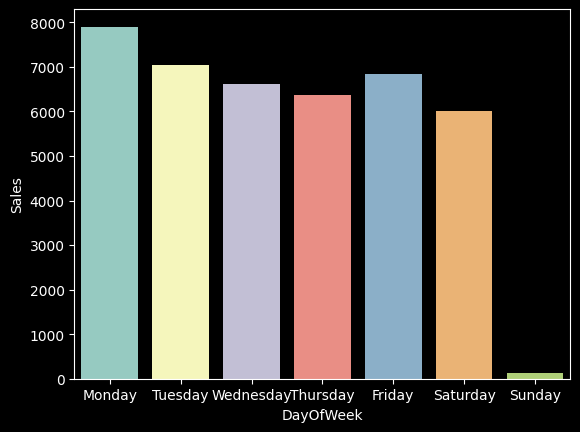

In [7]:
rosemangrp = roseman.groupby(['DayOfWeek'],as_index = False)
rosemangrp.groups
rosemangp = rosemangrp.agg({'Sales':np.mean})
rosemangp
rosemangp['DayOfWeek'] =rosemangp['DayOfWeek'].map({7:'Sunday',1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday'}).astype(str)
rosemangp
sns.barplot(x='DayOfWeek',y='Sales',data = rosemangp)


**Our Observations after anlysing weekdays sales**- On analysing we observe that Roseman store sales drops drastically on weekends especially on sundays mean people not prefer to go to stores on sundays and sales improve drastically on Monday and Tuesday it indicates that people prefer shopping on roseman stores on weekday and not on weekends.

**Monthly Sales Analysis**

<Axes: xlabel='Sales', ylabel='month'>

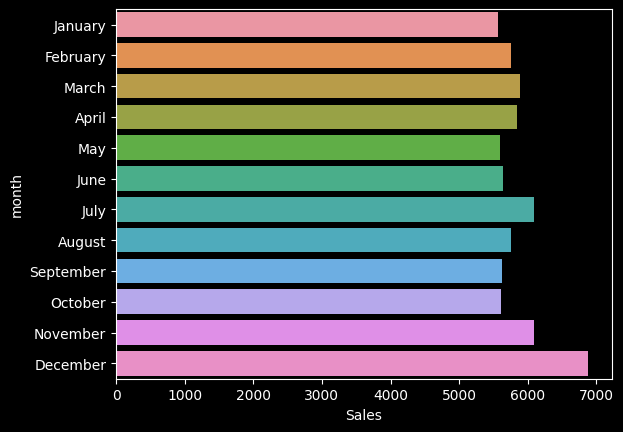

In [8]:
#4.1 Observing Monthly Sales of Roseman Stores
rosemangrpms = roseman.groupby(['month'],as_index = False)
rosemangrpms.groups
rosemangpms = rosemangrpms.agg({'Sales':np.mean})
rosemangpms
rosemangpms['month'] =rosemangpms['month'].map({1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}).astype(str)
rosemangpms
sns.barplot(x='Sales',y='month',data = rosemangpms)

**Our Observations on Rosemann Monthly Sales-** We observe that Santa Clause have special blessing on Roseman Stores means in month of December sales increases.

**Yearly Sales Analysis**

<Axes: xlabel='year', ylabel='Sales'>

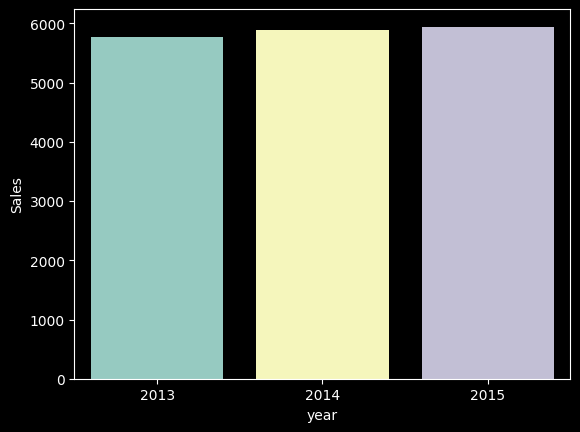

In [9]:
#4.2 Observing Yearly Sales of Roseman Stores
rosemangrpys = roseman.groupby(['year'],as_index = False)
rosemangrpys.groups
rosemangpys = rosemangrpys.agg({'Sales':np.mean})
rosemangpys
sns.barplot(x='year',y='Sales',data = rosemangpys)

**Our Observations on Roseman Store Yearly Sales Analysis -** While Observing yearly sales of Roseman Stores we observe that sales of Rosemann store stagnates on year on year basis. Roseman team have to work vey hard to increse the yearly sales.

In [10]:
#5 Merging of Roseman data with Store Data
rosemanall = store.merge(roseman,on=['Store ID'],how = 'left')
rosemanall.head()

,Store ID,StoreType,Assortment,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,day,week
0,1,1,0,1,13,2010,0,4,6884,716,1,1,0,0,2015,4,30,18
1,1,1,0,1,13,2010,0,3,6764,756,1,1,0,0,2015,4,29,18
2,1,1,0,1,13,2010,0,2,6861,678,1,1,0,0,2015,4,28,18
3,1,1,0,1,13,2010,0,1,6523,647,1,1,0,0,2015,4,27,18
4,1,1,0,1,13,2010,0,7,0,0,0,0,0,0,2015,4,26,17


**Feeling of Roseman Problem Using Exponential Moving Averages (EMA**)- Since Roseman problem is a problem of continous sales data. Exponential Moving Averages are (EMA) is a best indicator to analyse 
A. Trend in a Data - This means that sales data is in a uptrend or downtrend.
B. Seasonality in a data- This means where sales figure increases in some speciific timeframes.

For ananlysing regression problems Exponential Moving Average (EMA) figures gives complete picure of data. By analysing this data we are able to understand whether doing business is feasible what are the important opportunities when we are able to get optimum benifits.


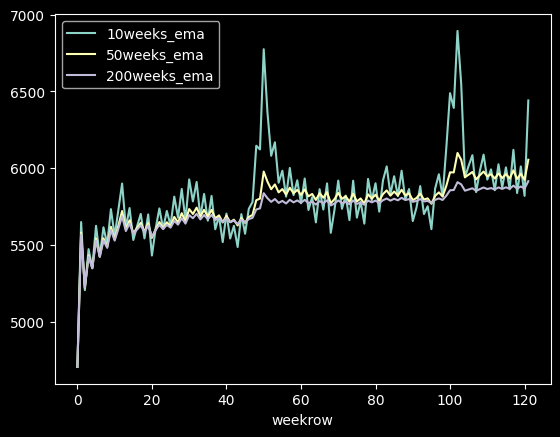

In [11]:
#6.1 Exponential Moving Average chart of Sales figure
rosemanall_weekly = rosemanall.groupby(['year','week'],as_index = False)
rosemanall_weekly.groups
rosemanall_weekly = rosemanall_weekly.agg({'Sales':np.mean})
rosemanll_weekly = rosemanall_weekly.sort_values(by = ['year','week'])
rosemanall_weekly['weekrow']= rosemanall_weekly.reset_index().index

rosemanall_weekly['10weeks_ema'] = rosemanall_weekly.Sales.ewm(span=10).mean()
rosemanall_weekly['50weeks_ema'] = rosemanall_weekly.Sales.ewm(span=50).mean()
rosemanall_weekly['200weeks_ema'] = rosemanall_weekly.Sales.ewm(span=200).mean()
rosemanall_weekly.plot('weekrow', ['10weeks_ema','50weeks_ema','200weeks_ema'])
plt.show()


Conclusion and Observations - While Analysing Exponential Moving Average chart Roseman sales we analyse following observations,
1. Trend - EMA chart analyse that Roseman data is in uptrend and it always above the 200 Exponential Moving Average figures but 200 EMA line is not a steep slope informs that Roseman sales figure is in slow uptrend.

2. Seasonlity - 10 days EMA chart figures shows that sales has upward seasonality and for some weeks sales figures improves drastically.


**Store Type Wise Exponential Moving Average Analysis** - While analysing database we observe that Roseman have four different types of stores. After analysing complete dataset, We now analyse Exponential Moving Average Analysis of Sales figures Storetype wise means how the behaviour of different store types in order to going deeper and understand how to improve sales.

In [12]:
#6.2Moving Average Chart of Store Wise Sales Figure
rosemanall_a = rosemanall.loc[rosemanall['StoreType'] == 1]
rosemanall_b = rosemanall.loc[rosemanall['StoreType'] == 2]
rosemanall_c = rosemanall.loc[rosemanall['StoreType'] == 3]
rosemanall_d = rosemanall.loc[rosemanall['StoreType'] == 4]

**STORETYPE A WEEKLY EMA CHART**

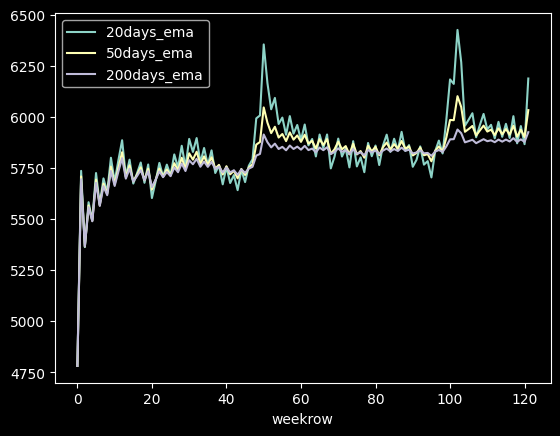

In [13]:
#6.3 EMA Analysis Storewise
rosemanall_a_weekly = rosemanall_a.groupby(['year','week'],as_index = False)
rosemanall_a_weekly.groups
rosemanall_a_weekly = rosemanall_a_weekly.agg({'Sales':np.mean})
rosemanll_weekly = rosemanall_a_weekly.sort_values(by = ['year','week'])
rosemanall_a_weekly['weekrow']= rosemanall_a_weekly.reset_index().index

rosemanall_a_weekly['20days_ema'] = rosemanall_a_weekly.Sales.ewm(span=20).mean()
rosemanall_a_weekly['50days_ema'] = rosemanall_a_weekly.Sales.ewm(span=50).mean()
rosemanall_a_weekly['200days_ema'] = rosemanall_a_weekly.Sales.ewm(span=200).mean()

rosemanall_a_weekly.plot('weekrow',['20days_ema','50days_ema','200days_ema'])
plt.show()


**STORETYPE B WEEKLY CHART**

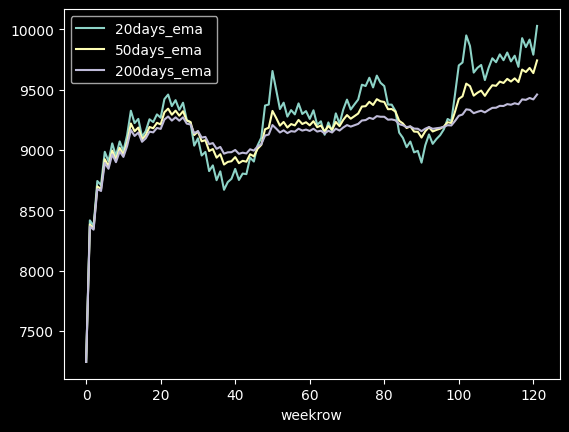

In [14]:
rosemanall_b_weekly = rosemanall_b.groupby(['year','week'],as_index = False)
rosemanall_b_weekly.groups
rosemanall_b_weekly = rosemanall_b_weekly.agg({'Sales':np.mean})
rosemanll_weekly = rosemanall_b_weekly.sort_values(by = ['year','week'])
rosemanall_b_weekly['weekrow']= rosemanall_b_weekly.reset_index().index

rosemanall_b_weekly['20days_ema'] = rosemanall_b_weekly.Sales.ewm(span=20).mean()
rosemanall_b_weekly['50days_ema'] = rosemanall_b_weekly.Sales.ewm(span=50).mean()
rosemanall_b_weekly['200days_ema'] = rosemanall_b_weekly.Sales.ewm(span=200).mean()

rosemanall_b_weekly.plot('weekrow',['20days_ema','50days_ema','200days_ema'])
plt.show()

**STORETYPE C EMA CHART**

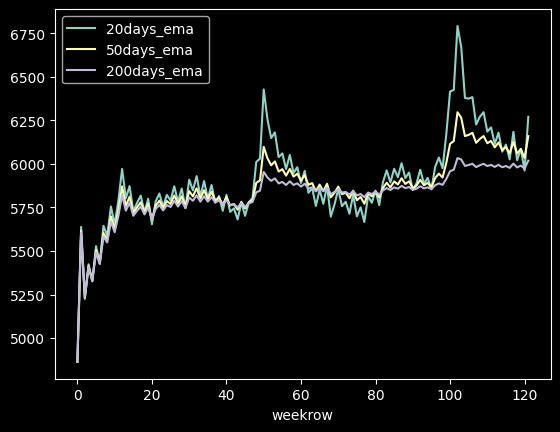

In [15]:
rosemanall_c_weekly = rosemanall_c.groupby(['year','week'],as_index = False)
rosemanall_c_weekly.groups
rosemanall_c_weekly = rosemanall_c_weekly.agg({'Sales':np.mean})
rosemanll_weekly = rosemanall_c_weekly.sort_values(by = ['year','week'])
rosemanall_c_weekly['weekrow']= rosemanall_c_weekly.reset_index().index
rosemanall_c_weekly['20days_ema'] = rosemanall_c_weekly.Sales.ewm(span=20).mean()
rosemanall_c_weekly['50days_ema'] = rosemanall_c_weekly.Sales.ewm(span=50).mean()
rosemanall_c_weekly['200days_ema'] = rosemanall_c_weekly.Sales.ewm(span=200).mean()

rosemanall_c_weekly.plot('weekrow',['20days_ema','50days_ema','200days_ema'])
plt.show()

**STORETYPE D WEEKLY EMA CHART**

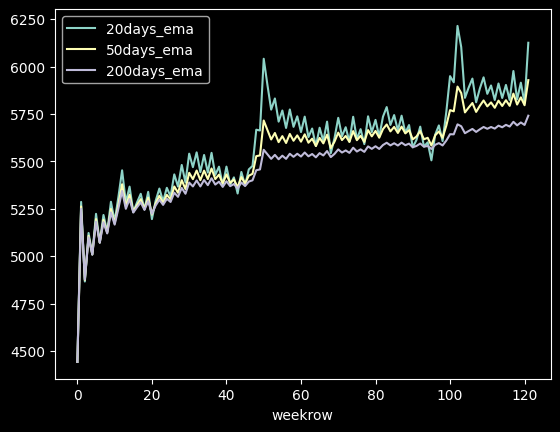

In [16]:
rosemanall_d_weekly = rosemanall_d.groupby(['year','week'],as_index = False)
rosemanall_d_weekly.groups
rosemanall_d_weekly = rosemanall_d_weekly.agg({'Sales':np.mean})
rosemanll_weekly = rosemanall_d_weekly.sort_values(by = ['year','week'])
rosemanall_d_weekly['weekrow']= rosemanall_d_weekly.reset_index().index
rosemanall_d_weekly['20days_ema'] = rosemanall_d_weekly.Sales.ewm(span=20).mean()
rosemanall_d_weekly['50days_ema'] = rosemanall_d_weekly.Sales.ewm(span=50).mean()
rosemanall_d_weekly['200days_ema'] = rosemanall_d_weekly.Sales.ewm(span=200).mean()

rosemanall_d_weekly.plot('weekrow',['20days_ema','50days_ema','200days_ema'])
plt.show()

# Our Observations and Conclusions after analysis of Roseman Storetype wise Exponential Moving Average Charts

After analysing consolidated data we now analyse Roseman Data Storewise. Following observations found 

1. STORETYPE A - While analysing Exponential Moving Average Chart of Store Type A we observe that 
 -Store type A sales figure in slight uptrend 20 days EMA never crosses 200 days EMA.
 -We observe seasonality in EMA chart and found sales of Storetype A sharply increase at Week 50 and week 105.

2. STORETYPE B - While analysing Exponential Moving Average Chart of Store Type B we observe that
  - Storetype B Sales figures are in strong uptrend and 20 days EMA never crosses 50 days EMA sales chart of Storetype B is very strong.
  - Although this chart is very strong we observe seasonality in upward seasonality at week 50 and week 105.

3. STORETYPE C - While analysing Exponential Moving Average Chart of Store Type C we observe that 
 -Store type A sales figure in slight uptrend 20 days EMA never crosses 200 days EMA.
 -We observe seasonality in EMA chart and found sales of Storetype A sharply increase at Week 50 and week 105.

4. STORETYPE D - While analysing Exponential Moving Average Chart of Store Type D we observe that 
 - Storetype D sales chart is in uptrend and better chart than Storetype A and C. In this EMA chart we observe that support of 20 days EMA at 50 days EMA
   and most of time 20 days EMA line not cuts downward 20 days EMA line.

After analysing all the EMA charts store wise we observe following out of all the store type Roseman has to focus aggresively on opening new Storetype B and D and 
focus on closure of Storetype A and C.Exponential Moving Average Analysis is a part of Time Series Analysis and Roseman problem is a time series analysis problem
our conclusion is that EMA chart analysis gives us very indepth understanding of Roseman sales.

Checking Target Variable is Balanced or Imbalance.

In [23]:
#7.0 Now checking the dataset target column balance
rosemanall['Sales'].value_counts()
 

0        41897
5977        62
5723        60
5558        59
4790        57
         ...  
23452        1
19680        1
20512        1
16191        1
1563         1
Name: Sales, Length: 17656, dtype: int64

In [17]:
#7.1 We Observe that Roseman Store problem is a Regression Problem 
uniq =rosemanall.nunique() 
uniq
y = rosemanall.Sales
y.count()
rosemanall.drop(['Sales'],axis =1)
X= rosemanall
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.3,random_state=123)

In [18]:
#7.2 Checking Numerical and Categorical Columns of a Dataset

colunique=X_train.nunique
cols= (X_train.nunique() < 8 )
cols
cat_cols = cols[cols==True].index.tolist()
num_cols = cols[cols==False].index.tolist()
cat_cols
num_cols
cat_cols_new = ['Promo2','Promo2SinceYear','DayOfWeek','Open','Promo','SchoolHoliday','year']
obj_cols = ['StoreType','Assortment','PromoInterval','StateHoliday']

**Predicting Roseman Sales using Linear Regression Model** - We observe that Roseman Sales problem is regression problem means predicted variable is in trend. We start with a very simple model i.e. Linear Regression model and we are using Pipeline to preprocess the data apply Linear Regression Model.

In [19]:
#8.1 Since Roseman Store is a regression problem we first build Linear Regresssion Model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import r2_score
from sklearn.preprocessing import OrdinalEncoder
SS = StandardScaler()
OHE = OneHotEncoder()
OE  = OrdinalEncoder()
LR = LinearRegression()


preprocess = make_column_transformer(
                                     (SS,num_cols),
                                     (OHE,obj_cols)
                                     )

pipeline_linreg = make_pipeline(preprocess,LR)


#8.2 Fit the Pipeline in Training data

pipeline_linreg.fit(X_train,y_train)

#8.3 Predict the Pipeline in test data

y_predict_linreg = pipeline_linreg.predict(X_test)


In [20]:
#8.4 Score of Linear Regrssion pipeline 

score_linreg =r2_score(y_predict_linreg,y_test)
score_linreg

1.0

In [21]:
rmse = np.sqrt(mean_squared_error(y_test,y_predict_linreg)) 
rmse

3.590899250394674e-11

Conclusion of Linear Regression Model - We observe that Root Mean Square Error figures are fine, in this model we are getting excellent score of 1. Our personal opionion on this model we are getting score 1 means some over fitting issues in this model. 

**Regularization of Linear Regression Model Using Elastic Net. Elastic Net uses both Lasso and Ridge regression** - Since Linear Regression model gives very high scores we now do some regularisation using Elastic Net regularisation which uses both Lasso and Redge regressions. Theory of Lasso and Redge regression is given below.

Courtsey- Towards Datascience
**Linear regression (in scikit-learn**) is the most basic form, where the model is not penalized for its choice of weights, at all. That means, during the training stage, if the model feels like one particular feature is particularly important, the model may place a large weight to the feature. This sometimes leads to overfitting in small datasets. Hence, following methods are invented.
**Lasso** is a modification of linear regression, where the model is penalized for the sum of absolute values of the weights. During training, the objective function become:
Image for post
As you see, Lasso introduced a new hyperparameter, alpha, the coefficient to penalize weights.
**Ridg**e takes a step further and penalizes the model for the sum of squared value of the weights. Thus, the weights not only tend to have smaller absolute values and more evenly distributed, but also tend to be close to zeros. The objective function becomes:
Image for post
**ElasticNet** is a hybrid of Lasso and Ridge, where both the absolute value penalization and squared penalization are included, being regulated with another coefficient l1_ratio:

In [23]:
#4.3 Regressioin Ananlysis using Elastic Net. Elastic net uses both Lasso and Ridge regressions.
# Regularisastion of Linear Regression Model using L1 and L2 regularization.

from sklearn.linear_model import ElasticNet

EN = ElasticNet()
pipeline_elasticnet = make_pipeline(preprocess,EN)
parameters = {'elasticnet__l1_ratio':np.linspace(0,1,30)}

# Calling Grid Search CV 
Grid_Search_EN = GridSearchCV(pipeline_elasticnet,parameters)
Grid_Search_EN.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['Store '
                                                                          'ID',
                                                                          'Promo2SinceWeek',
                                                                          'Sales',
                                                                          'Customers',
                                                                          'month',
                                                                          'day',
                                                                          'week']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['StoreType',
                                                                          'Assortment',
                                                                          'PromoInterval',
                                                                          'StateHoliday'])])),
                                       ('elasticnet', ElasticNet())]),
             param_grid={'elasticnet__l1_ratio': array([0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
       0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
       0.34482759, 0.37931034, 0.4137931 , 0.44827586, 0.48275862,
       0.51724138, 0.55172414, 0.5862069 , 0.62068966, 0.65517241,
       0.68965517, 0.72413793, 0.75862069, 0.79310345, 0.82758621,
       0.86206897, 0.89655172, 0.93103448, 0.96551724, 1.        ])})

In [24]:
# Compute and print the scores
r2 = Grid_Search_EN.score(X_test,y_test)
print("Tuned ElasticNet Alpha: {}".format(Grid_Search_EN.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))

Tuned ElasticNet Alpha: {'elasticnet__l1_ratio': 1.0}
Tuned ElasticNet R squared: 0.9999999377920943


Courtsey- Wikipedia
Evaluation using Random Forest Regressor Model- Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean/average prediction (regression) of the individual trees.[1][2] Random decision forests correct for decision trees' habit of overfitting to their training set.[3]:587–588 Random forests generally outperform decision trees, but their accuracy is lower than gradient boosted trees.

In [25]:
#9.1 Roseman Store problem using Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

RF = RandomForestRegressor(max_depth = None)

pipeline_rf = make_pipeline(preprocess,RF)

parameters = {'randomforestregressor__n_estimators': [100, 200, 300], 
              'randomforestregressor__max_depth': [None]}

# Rufen Sie Grid Search CV auf
Grid_Search_RFR = GridSearchCV(pipeline_rf, parameters)
Grid_Search_RFR.fit(X_train, y_train)


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['Store '
                                                                          'ID',
                                                                          'Promo2SinceWeek',
                                                                          'Sales',
                                                                          'Customers',
                                                                          'month',
                                                                          'day',
                                                                          'week']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['StoreType',
                                                                          'Assortment',
                                                                          'PromoInterval',
                                                                          'StateHoliday'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             param_grid={'randomforestregressor__max_depth': [None],
                         'randomforestregressor__n_estimators': [100, 200,
                                                                 300]})

In [27]:
Grid_Search_RFR.best_params_

{'randomforestregressor__max_depth': None,
 'randomforestregressor__n_estimators': 200}

In [29]:
# y_predict_rf = Grid_Search_RFR.score(X_test, y_test)
# score_rf = r2_score(y_predict_rf, y_test)
# score_rf


# Compute and print the scores
r2 = Grid_Search_RFR.score(X_test, y_test)
print("Tuned ElasticNet Alpha: {}".format(Grid_Search_RFR.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))

Tuned ElasticNet Alpha: {'randomforestregressor__max_depth': None, 'randomforestregressor__n_estimators': 200}
Tuned ElasticNet R squared: 0.999999714684544


0.9999999377920943

0.9999996923246569

**Our Observations and Conclusion for Random Forest Model** We observe that Random Forest model gives nice results but at the same time Linear Regression which is a simple model also gives best results.

**Prediction of Roseman Sales using XGBoost Model** - XG Boost Model is one of best model for hyper parameter tuning we analyse sales figures using XG Boost Model by using cross validation, Grid Search CV and Random Search CV. 

In [27]:
#10.1 Prediction of Roseman Problem using XGBoost Algorithm
from xgboost.sklearn import XGBRegressor
SS = StandardScaler()
xgb = XGBRegressor()
pipeline_xg = make_pipeline (preprocess,SS,xgb)

#10.2 Doing Grid Search using XG Boost
pipeline_xg.get_params

parameters = {
               'xg__learning_rate':  [0.03, 0.05],
                'xg__n_estimators':   [200,  300], 
                'xg__max_depth':      [4,6]
            }


clf = GridSearchCV(estimator = pipeline_xg,param_grid= parameters,scoring="neg_mean_squared_error",cv=4,verbose=1)
                   


#10.3 Start fitting Data into pipeline


clf.fit(X_train, y_train)


Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ValueError: Invalid parameter xg for estimator Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Store', 'Promo2SinceWeek',
                                                   'Sales', 'Customers',
                                                   'month', 'day', 'week']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['StoreType', 'Assortment',
                                                   'PromoInterval',
                                                   'StateHoliday'])])),
                ('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=None,...
                              importance_type='gain',
                              interaction_constraints=None, learning_rate=None,
                              max_delta_step=None, max_depth=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=None, reg_alpha=None,
                              reg_lambda=None, scale_pos_weight=None,
                              subsample=None, tree_method=None,
                              validate_parameters=None, verbosity=None))]). Check the list of available parameters with `estimator.get_params().keys()`.

In [28]:
#10.4 CROSS VALIDATION XG BOOST MODEL USING PIPELINE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from xgboost.sklearn import XGBRegressor
steps = [("pp",preprocess),("SS",StandardScaler()),
         ("xgb_model", XGBRegressor(max_depth=2, objective="reg:linear"))]

xgb_pipeline = Pipeline(steps)

**Cross Validataion Scores for Extreme Boost Model**

In [29]:
cross_val_scores = cross_val_score(xgb_pipeline,X_train,y_train,cv=10,scoring = "neg_mean_squared_error")
cross_val_scores

[07:53:20] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[07:53:37] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[07:53:39] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[07:53:56] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[07:53:58] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[07:54:17] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[07:54:19] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[07:54:36] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[07:54:38] WARNING: ../src/objective/regression_

array([-7309.84632082, -7121.24771787, -7263.47949067, -7413.95677507,
       -7156.05316124, -6944.87595903, -7133.2144085 , -7267.21193386,
       -7024.28153384, -7302.55729598])

In [30]:
#10.5 Doing Grid Search CV using XG Boost Model
gbm_param_grid = {
        'xgb_model__n_estimat ors': [50],
    'xgb_model__max_depth': [2, 5]
}
grid_mse = GridSearchCV(estimator=xgb_pipeline,param_grid=gbm_param_grid,scoring="neg_mean_squared_error",cv=4,verbose=1)

grid_mse.fit(X_train,y_train)



Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[07:56:36] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[07:56:36] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimat ors } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:56:50] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[07:56:52] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[07:56:52] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimat ors } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.1min finished


[07:59:45] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:45] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimat ors } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:00:24] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['Store',
                                                                          'Promo2SinceWeek',
                                                                          'Sales',
                                                                          'Customers',
                                                                          'month',
                                                                          'day',
                                                                          'week']),
                                                                        ('onehotencoder',
                                                                     

**Best Parameter Scores for XG Boost Model using Grid Search**

In [31]:
best_param = grid_mse.best_params_
best_param

{'xgb_model__max_depth': 5, 'xgb_model__n_estimat ors': 50}

Best Scores for XG Boost Scores using Grid Search

In [32]:
best_score = grid_mse.best_score_
best_score

-138.10688322545667

**Lowest RMSE for Grid Search using XGBoost**

In [33]:
Lowest_RMSE_gs = np.sqrt(np.abs(best_score))
Lowest_RMSE_gs

11.75188849612932

**Final Conclusion** - Roseman problem is an interesting problem to analyse future sales. In this notesheet we analyse both past sales using Exponential Moving Averages, analyse the trend and seasonality in Roseman Sales figures. We observe that oveall sales figures of Roseman store are stuck from last three years it is in very week uptrend.

We observe that Roseman have four different types of stores, in this sheet we also analyse the performance of different store types using Exponential Moving Average. We observe that performance of store B is outstanding as compared to performance of all other stores. Our recommendation are that Roseman team has to focus more on Store Type B and D and focus for closure of Store A and C.

We observe that performance of models are also nice to predict future Roseman Sales.

**Being an initial Learner, i try my best to understand and predict Roseman Sales. Your UPVOTES will definitely encourage to do best. Your suggestions to improve better are highly Appreciable to do better in future.**